In [21]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import numpy as np
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

In [22]:
batch_size = 1024
epochs = 100
sample_size = 64
latent_dim = 128
k = 1
# device = torch.device('mps' if torch.mps.is_available() else 'cpu')
device = torch.device('mps')

transform = transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,)),
           ])

In [23]:
train_data = datasets.MNIST(
   root='./input/data',
   train=True,
   download=True,
   transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [24]:
params = {"learning_rate": 0.0002,
         "optimizer": "Adam",
         "optimizer_betas": (0.5, 0.999),
         "latent_dim": latent_dim}

# run["parameters"] = params

In [25]:
class Generator(nn.Module):
   def __init__(self, latent_space):
       super(Generator, self).__init__()
       self.latent_space = latent_space
       self.fcn = nn.Sequential(
           nn.Linear(in_features=self.latent_space, out_features=128*7*7),
           nn.LeakyReLU(0.2),
       )

       self.deconv = nn.Sequential(
           nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
           nn.LeakyReLU(0.2),

           nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
           nn.LeakyReLU(0.2),

           nn.Conv2d(in_channels=128, out_channels=1, kernel_size=(3, 3), padding=(1, 1)),
           nn.Tanh()
       )

   def forward(self, x):
       x = self.fcn(x)
       x = x.view(-1, 128, 7, 7)
       x = self.deconv(x)
       return x

In [26]:
class Discriminator(nn.Module):
   def __init__(self):
       super(Discriminator, self).__init__()
       self.conv = nn.Sequential(
           nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
           nn.LeakyReLU(0.2),

           nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
           nn.LeakyReLU(0.2)
       )
       self.classifier = nn.Sequential(
           nn.Linear(in_features=3136, out_features=1),
           nn.Sigmoid()
       )

   def forward(self, x):
       x = self.conv(x)
       x = x.view(x.size(0), -1)
       x = self.classifier(x)
       return x

In [27]:
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

optim_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

criterion = nn.BCELoss()
def label_real(size):
   labels = torch.ones(size, 1)
   return labels.to(device)
def label_fake(size):
   labels = torch.zeros(size, 1)
   return labels.to(device)
def create_noise(sample_size, latent_dim):
   return torch.randn(sample_size, latent_dim).to(device)

In [28]:
def train_generator(optimizer, data_fake):
   b_size = data_fake.size(0)
   real_label = label_real(b_size)
   optimizer.zero_grad()
   output = discriminator(data_fake)
   loss = criterion(output, real_label)
   loss.backward()
   optimizer.step()
   return loss

In [29]:
def train_discriminator(optimizer, data_real, data_fake):
   b_size = data_real.size(0)
   real_label = label_real(b_size)
   fake_label = label_fake(b_size)
   optimizer.zero_grad()
   output_real = discriminator(data_real)
   loss_real = criterion(output_real, real_label)
   output_fake = discriminator(data_fake)
   loss_fake = criterion(output_fake, fake_label)
   loss_real.backward()
   loss_fake.backward()
   optimizer.step()
   return loss_real, loss_fake

59it [00:29,  2.03it/s]                        


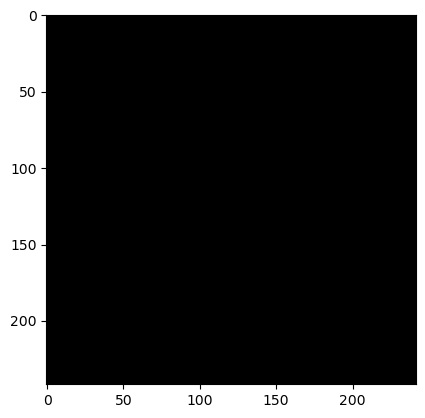

59it [00:28,  2.08it/s]                        


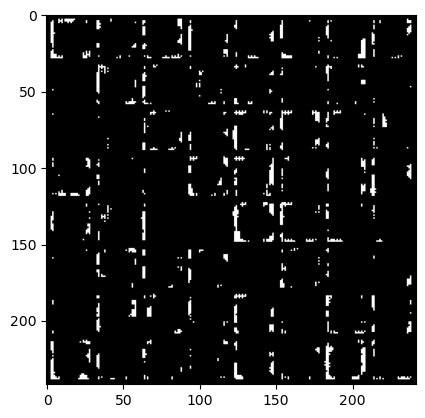

59it [00:28,  2.09it/s]                        


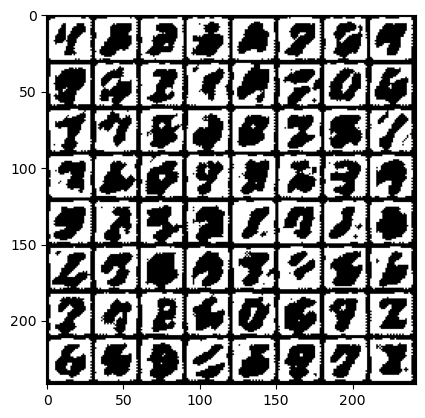

59it [00:28,  2.10it/s]                        


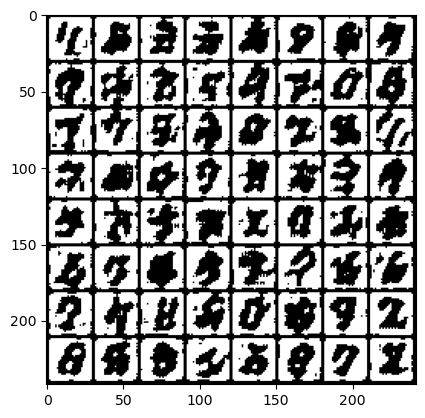

59it [00:28,  2.09it/s]                        


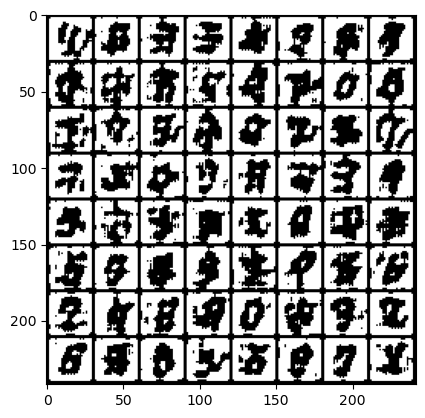

 21%|██        | 12/58 [00:05<00:22,  2.00it/s]


KeyboardInterrupt: 

In [30]:
noise = create_noise(sample_size, latent_dim)
generator.train()
discriminator.train()

for epoch in range(epochs):
    loss_g = 0.0
    loss_d_real = 0.0
    loss_d_fake = 0.0

    # training
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data) / train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        for step in range(k):
            data_fake = generator(create_noise(b_size, latent_dim)).detach()
            data_real = image
            loss_d_fake_real = train_discriminator(optim_d, data_real, data_fake)
            loss_d_real += loss_d_fake_real[0]
            loss_d_fake += loss_d_fake_real[1]
        data_fake = generator(create_noise(b_size, latent_dim))
        loss_g += train_generator(optim_g, data_fake)

    # inference and observations
    generated_img = generator(noise).cpu().detach()
    generated_img = make_grid(generated_img)
    generated_img = np.moveaxis(generated_img.numpy(), 0, -1)
    plt.imshow(generated_img.astype(np.uint8))
    plt.show()